# Clustering of HCP Unrelated 100 Subjects by ROI-Correlations in Resting State

## Import and Setup

In [1]:
from Main import get_timeseries_per_patient, timeseries_pearson_corr, get_centroids_per_region, create_network_graph_frames, plot_in_orientation
from Import import get_parcellation_data, img_data_loader
from glob import glob
from matplotlib.lines import Line2D
from matplotlib.colors import ListedColormap
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearnex import patch_sklearn
patch_sklearn()
import re
import os
import cv2
import nibabel as nib
import nilearn.image as nimg
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
%matplotlib inline

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [2]:
# import all timeseries
files = glob("D:/HCP/Unrelated 100/Patients/timeseries/*")
all_timeseries = [np.load(file) for file in files]
len(all_timeseries)

100

In [3]:
# import all centroids
files = glob("./Data/centroids/*")
all_centroids = np.concatenate([np.load(file) for file in files], axis=0)
all_centroids

array([[64.46511628, 59.51928531, 60.82019285],
       [24.44957113, 58.22508134, 61.40490979],
       [54.38649625, 79.74492915, 56.47707697],
       [34.1984714 , 77.95512821, 57.25221893],
       [53.41225337, 85.95950156, 28.64070613],
       [35.9107322 , 86.30892678, 28.25275827],
       [61.87949825, 78.7446021 , 53.06539173],
       [26.30407524, 78.87539185, 52.40713166],
       [60.44256757, 87.57094595, 30.50675676],
       [28.55270936, 88.63743842, 29.92906404],
       [69.39788054, 68.74566474, 44.90077071],
       [20.03645461, 69.83774124, 46.09792709],
       [67.94503756, 77.33333333, 42.29141953],
       [19.9693166 , 77.45095305, 42.40864714],
       [63.12011834, 77.74615385, 29.2704142 ],
       [24.54481547, 78.4973638 , 29.37082601],
       [68.7030303 , 58.11212121, 42.31919192],
       [18.80916604, 59.23140496, 42.6649136 ],
       [47.84536563, 64.77503493, 66.03213787],
       [40.87684521, 62.45339519, 66.25643189],
       [49.13214286, 69.93214286, 29.657

In [4]:
# load atlas data
region_maps, region_maps_data, masked_aal, regions, region_labels = get_parcellation_data(fetched=True)

In [5]:
region_labels

array([['FAG', 'Precentral_L', '2001'],
       ['FAD', 'Precentral_R', '2002'],
       ['F1G', 'Frontal_Sup_L', '2101'],
       ['F1D', 'Frontal_Sup_R', '2102'],
       ['F1OG', 'Frontal_Sup_Orb_L', '2111'],
       ['F1OD', 'Frontal_Sup_Orb_R', '2112'],
       ['F2G', 'Frontal_Mid_L', '2201'],
       ['F2D', 'Frontal_Mid_R', '2202'],
       ['F2OG', 'Frontal_Mid_Orb_L', '2211'],
       ['F2OD', 'Frontal_Mid_Orb_R', '2212'],
       ['F3OPG', 'Frontal_Inf_Oper_L', '2301'],
       ['F3OPD', 'Frontal_Inf_Oper_R', '2302'],
       ['F3TG', 'Frontal_Inf_Tri_L', '2311'],
       ['F3TD', 'Frontal_Inf_Tri_R', '2312'],
       ['F3OG', 'Frontal_Inf_Orb_L', '2321'],
       ['F3OD', 'Frontal_Inf_Orb_R', '2322'],
       ['ORG', 'Rolandic_Oper_L', '2331'],
       ['ORD', 'Rolandic_Oper_R', '2332'],
       ['SMAG', 'Supp_Motor_Area_L', '2401'],
       ['SMAD', 'Supp_Motor_Area_R', '2402'],
       ['COBG', 'Olfactory_L', '2501'],
       ['COBD', 'Olfactory_R', '2502'],
       ['FMG', 'Frontal_Sup_Medial

In [6]:
# setup
patients = ["100307", "100408", "101107", "101309", "101915", "103111", "103414", "103818", "105014", "105115", "106016", "108828", "110411", "111312", "111716", "113619", "113922", "114419", "115320", "116524", "117122", "118528", "118730", "118932", "120111", "122317", "122620", "123117", "123925", "124422", "125525", "126325", "127630", "127933", "128127", "128632", "129028", "130013", "130316", "131217", "131722", "133019", "133928", "135225", "135932", "136833", "138534", "139637", "140925", "144832", "146432", "147737", "148335", "148840", "149337", "149539", "149741", "151223", "151526", "151627", "153025", "154734", "156637", "159340", "160123", "161731", "162733", "163129", "176542", "178950", "188347", "189450", "190031", "192540", "196750", "198451", "199655", "201111", "208226", "211417", "211720", "212318", "214423", "221319", "239944", "245333", "280739", "298051", "366446", "397760", "414229", "499566", "654754", "672756", "751348", "756055", "792564", "856766", "857263", "899885"]
patient_id = "100307"
patient_num = patients.index(patient_id)

timestamp = 70

# region_to_plot = "F3TG"
# region_to_plot = "VER9"
region_to_plot = str("ING")
region_index = np.where(region_labels == region_to_plot)
region_id = int(region_labels[region_index[0],2])

# slices for "F3TG"
# sagittal_slice = 70
# coronal_slice = 70
# transversal_slice = 45

# slices for center
sagittal_slice = int(91/2)
coronal_slice = int(109/2)
transversal_slice = int(91/2)

# setup colors
regions_n = len(regions)
colors = plt.cm.turbo(np.linspace(0, 1, regions_n))

correlation_threshold = 0.9

In [7]:
# load Average T1w Image
path_T1w = "./Data/S1200_AverageT1w_restore.nii.gz"
img_T1w, img_data_T1w = img_data_loader(path_T1w)

In [8]:
# load specific fMRI Image
path_fMRI = os.path.join("D:/HCP/Unrelated 100/Patients", patient_id, "MNINonLinear/Results/rfMRI_REST1_LR/rfMRI_REST1_LR_hp2000_clean.nii.gz")
img_fMRI = nib.load(path_fMRI)
short, long = min(img_fMRI.shape[:3]), max(img_fMRI.shape[:3])

## Visualize Brain Regions

In [10]:
# resample Images to region labels
resampled_img_data_T1w = nimg.resample_to_img(img_T1w, region_maps, interpolation='nearest').get_fdata()
resampled_img_fMRI = nimg.resample_to_img(img_fMRI, region_maps, interpolation='nearest') if img_fMRI.shape[0:3] != region_maps.shape else img_fMRI
resampled_img_data_fMRI = resampled_img_fMRI.dataobj[:, :, :, timestamp]
# mask all but the chosen region
masked_aal_region = np.ma.masked_where(masked_aal != region_id, masked_aal)
# mask so that values of 0 are not shown
resampled_img_data_fMRI_masked = np.ma.masked_where(resampled_img_data_fMRI == 0, resampled_img_data_fMRI)

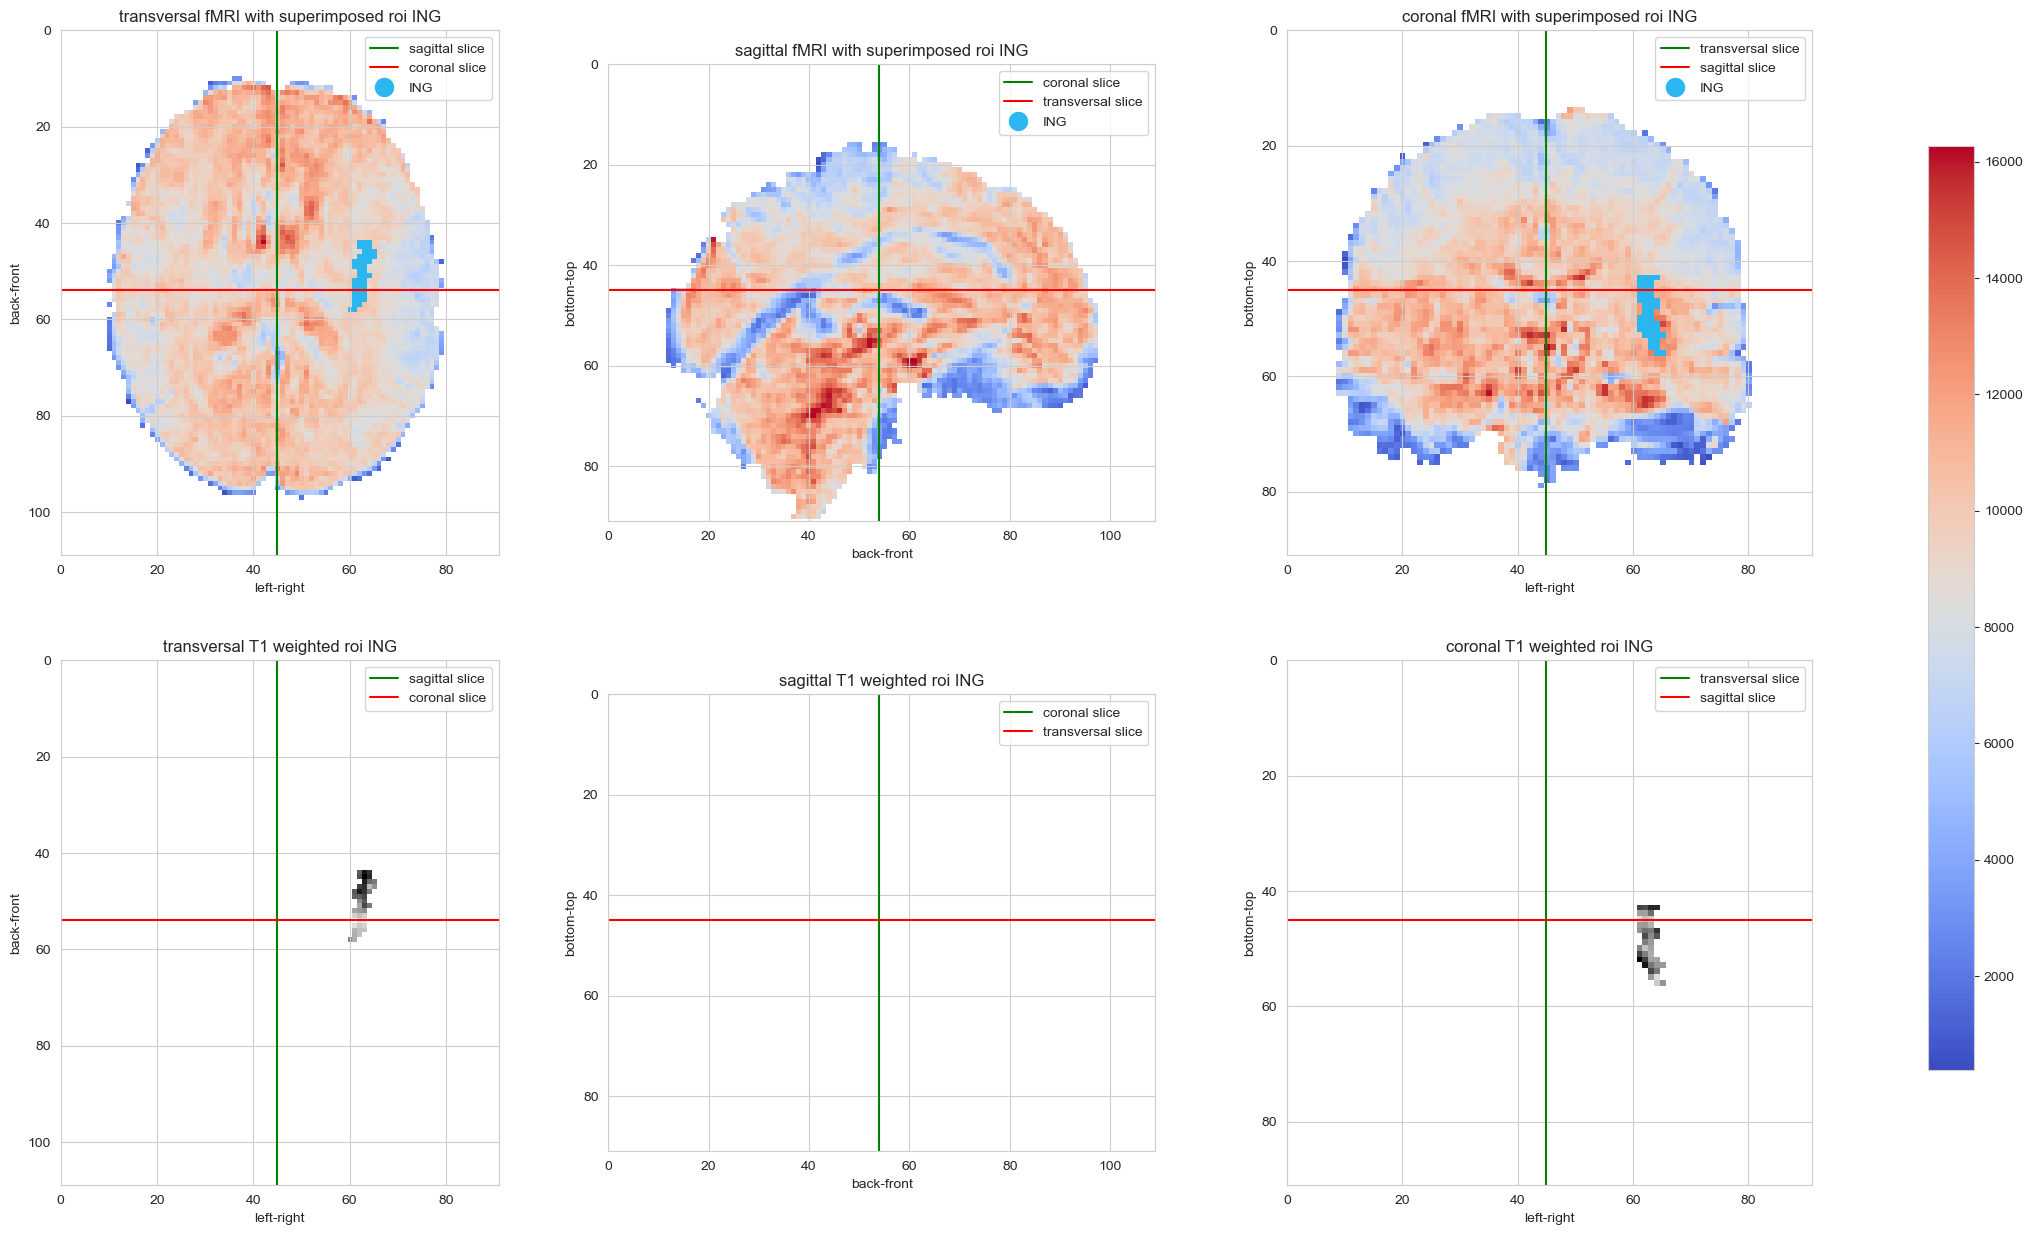

In [11]:
fig, axs = plt.subplots(2,3, figsize=(30,15))
orientations = ['transversal', 'sagittal', 'coronal']
slices = [transversal_slice, sagittal_slice, coronal_slice]
legend_element = [
    Line2D([0], [0], marker='o', color='w', label=region_to_plot, markerfacecolor=colors[region_index[0], :], markersize=15)
]
for plot in np.arange(2):
    for orientation_num, orientation in enumerate(orientations):
        if plot == 0:
            # plot fMRI-image with roi
            image = plot_in_orientation(resampled_img_data_fMRI_masked, orientation, slices[orientation_num], ax=axs[plot, orientation_num], cmap="coolwarm")
            plot_in_orientation(masked_aal_region, orientation, slices[orientation_num], cmap=ListedColormap(colors[region_index, :]), ax=axs[plot, orientation_num], label=region_to_plot)
            # set title
            axs[plot, orientation_num].set_title(f"{orientation} fMRI with superimposed roi {region_to_plot}")
        else:
            # plot region
            resampled_img_data_fMRI_oneRegionOnly = resampled_img_data_fMRI * (region_maps_data == region_id)
            masked_region = np.ma.masked_where(resampled_img_data_fMRI_oneRegionOnly == 0,
                                           resampled_img_data_fMRI_oneRegionOnly)
            plot_in_orientation(masked_region, orientation, slices[orientation_num], ax=axs[plot, orientation_num])
            # set title
            axs[plot, orientation_num].set_title(f"{orientation} T1 weighted roi {region_to_plot}")

        if orientation_num == 0:
            # transversal ax labels and limits
            axs[plot, 0].set_xlabel("left-right")
            axs[plot, 0].set_ylabel("back-front")
            axs[plot, 0].set_xlim(0, short)
            axs[plot, 0].set_ylim(long, 0)
            # plot slice indicators
            axs[plot, 0].plot([sagittal_slice, sagittal_slice], [0, long], color="green", label="sagittal slice")
            axs[plot, 0].plot([0, short], [coronal_slice, coronal_slice], color="red", label="coronal slice")
            axs[plot, 0].legend()
        elif orientation_num == 1:
            # sagittal ax labels and limits
            axs[plot, 1].set_xlabel("back-front")
            axs[plot, 1].set_ylabel("bottom-top")
            axs[plot, 1].set_xlim(0, long)
            axs[plot, 1].set_ylim(short, 0)
            # plot slice indicators
            axs[plot, 1].plot([coronal_slice, coronal_slice], [0, 91], color="green", label="coronal slice")
            axs[plot, 1].plot([0, 109], [transversal_slice, transversal_slice], color="red", label="transversal slice")
            axs[plot, 1].legend()
        else:
            # coronal ax labels and limits
            axs[plot, 2].set_xlabel("left-right")
            axs[plot, 2].set_ylabel("bottom-top")
            axs[plot, 2].set_xlim(0, short)
            axs[plot, 2].set_ylim(short, 0)
            # plot slice indicators
            axs[plot, 2].plot([transversal_slice, transversal_slice], [0, 91], color="green", label="transversal slice")
            axs[plot, 2].plot([0, 91], [sagittal_slice, sagittal_slice], color="red", label="sagittal slice")
            axs[plot, 2].legend()

        if plot == 0:
            # combine legends from region overlay with slice indicators
            handles, labels = axs[0, orientation_num].get_legend_handles_labels()
            handles += legend_element
            labels += [region_to_plot]
            axs[0, orientation_num].legend(handles, labels)

cbar = fig.colorbar(image, ax=axs.ravel().tolist(), shrink=0.8)

## Visualize Timeseries

In [11]:
# extract single patients timeseries
timeseries = all_timeseries[patient_num]
timeseries_mean = timeseries - np.mean(timeseries, axis=0)

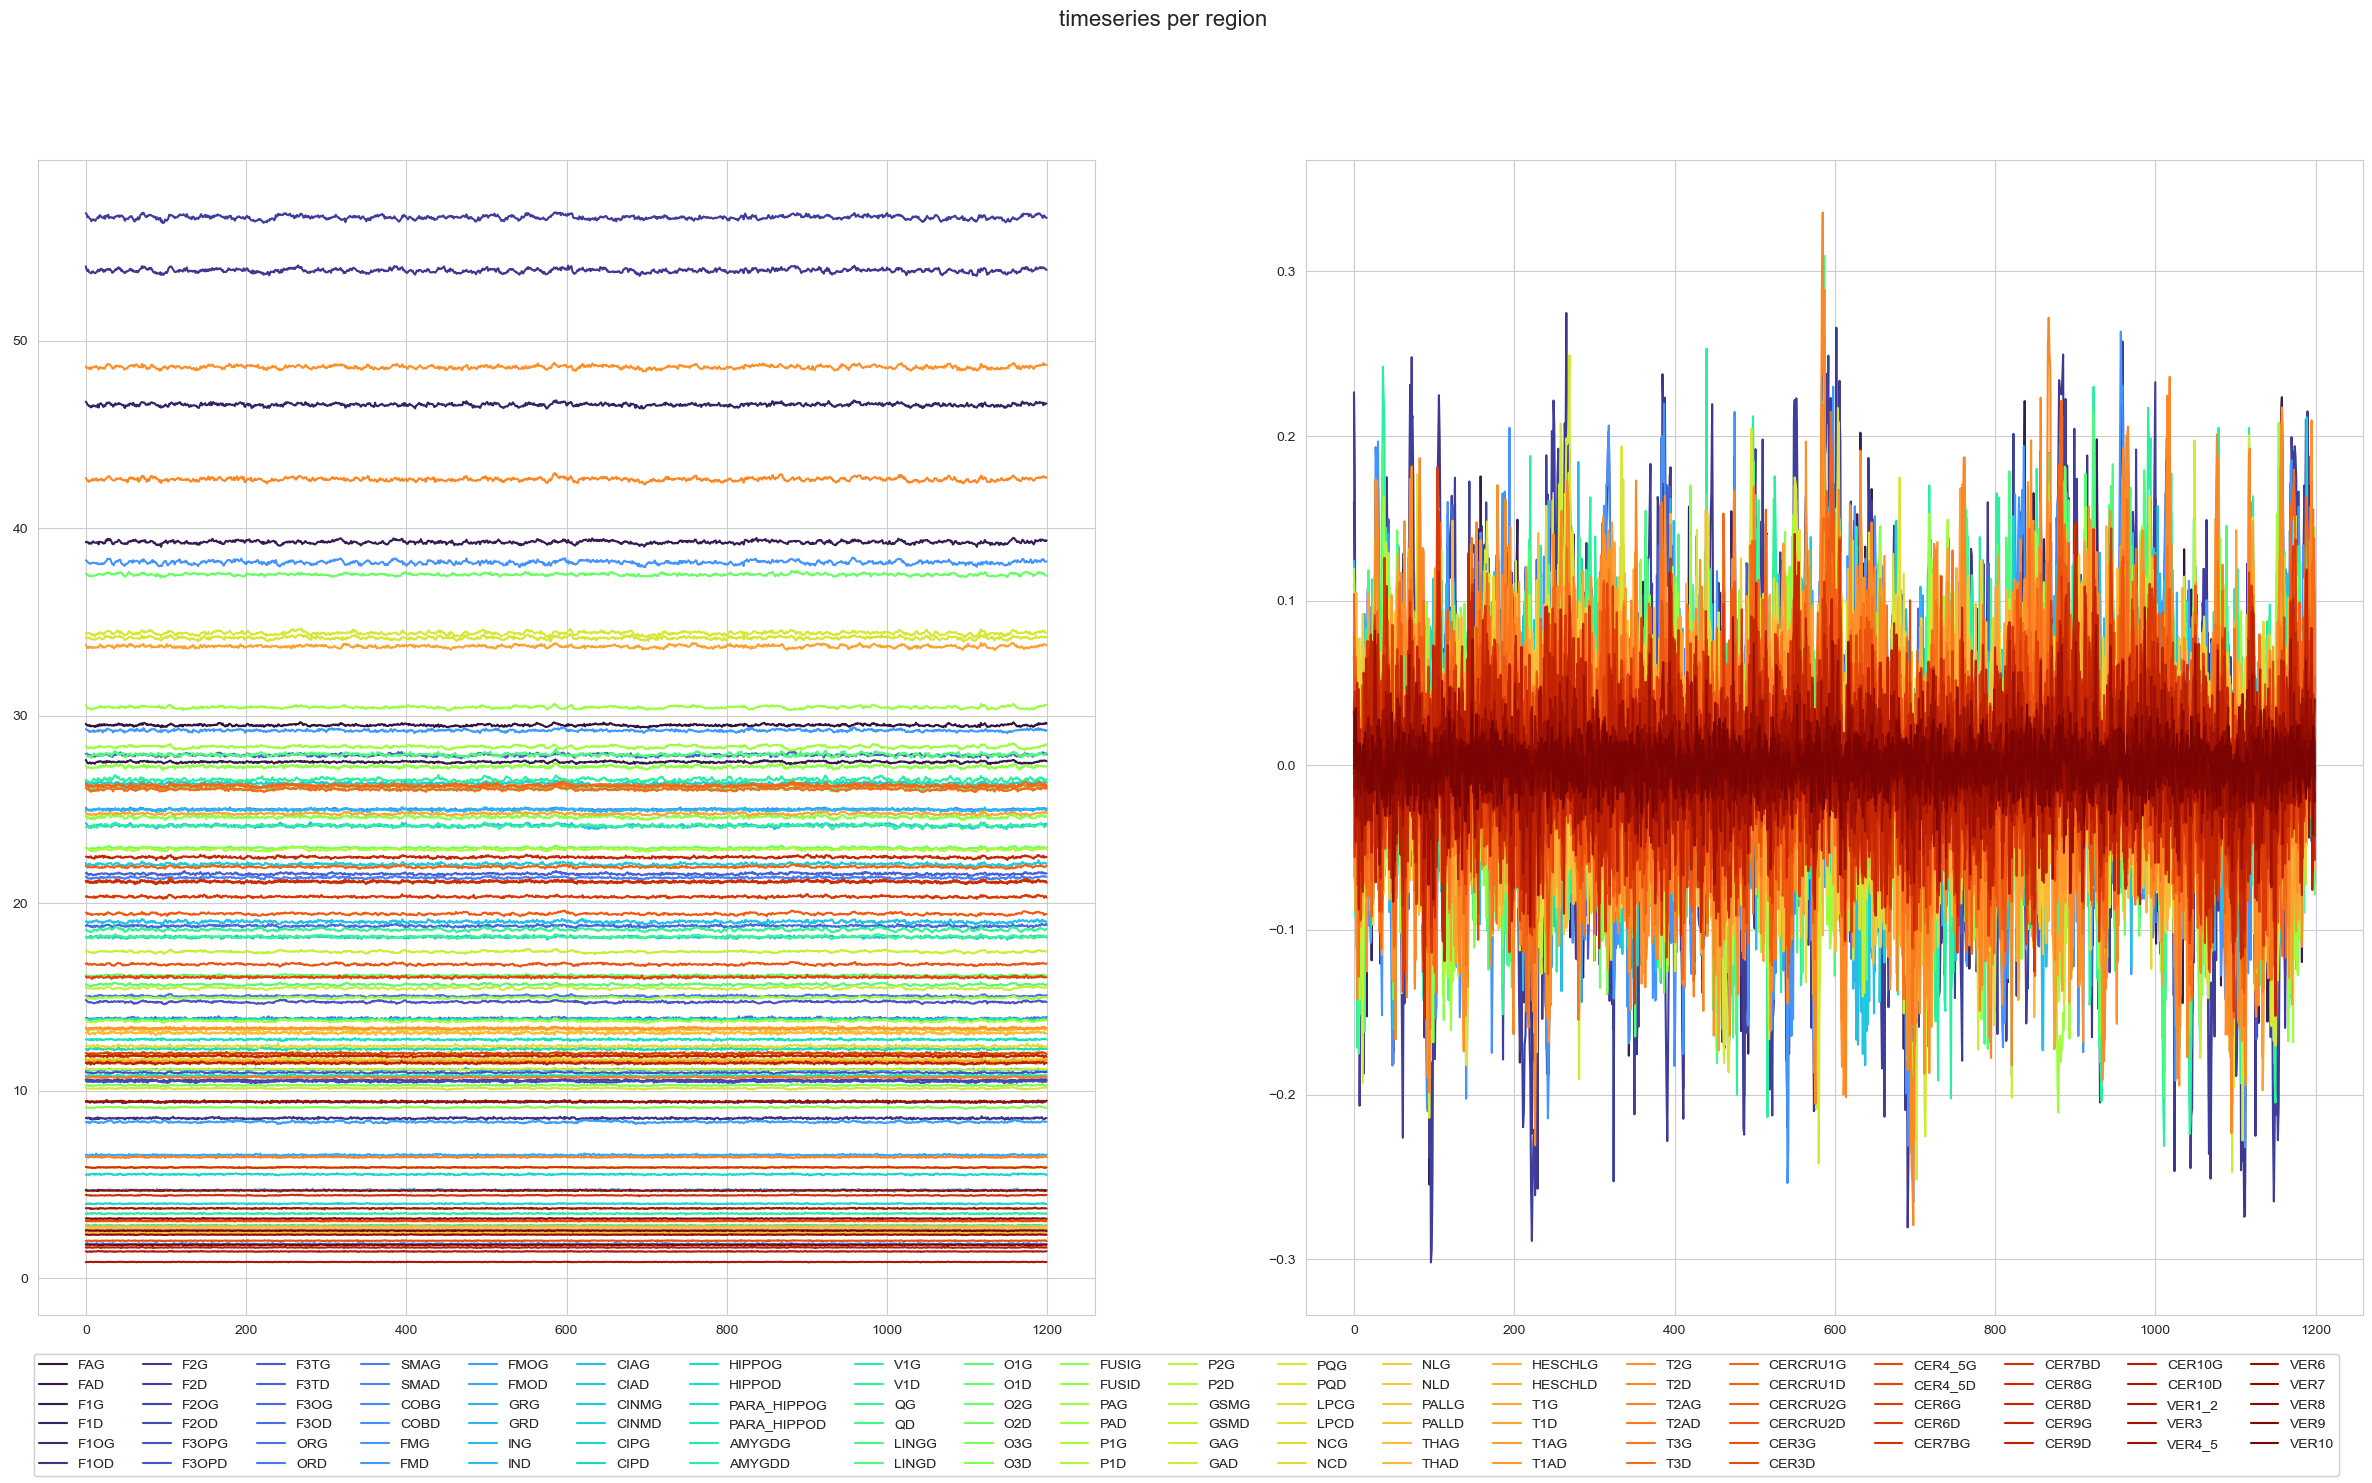

In [12]:
# plot the patients timeseries
fig, axs = plt.subplots(ncols=2, nrows=1, figsize=(30, 15))
for region_num in range(regions_n):
    axs[0].plot(timeseries[:, region_num], color=colors[region_num])
    axs[1].plot(timeseries_mean[:, region_num], color=colors[region_num])
fig.suptitle("timeseries per region", fontsize=16)
legend = fig.legend(region_labels[:, 0], loc="lower center", ncols=20)
fig.add_artist(legend);
plt.savefig(os.path.join("./Data/", "timeseries.png"))

## Compute Pearson`s r

In [13]:
# compute correlation between regions in sliding window
correlation_matrices_per_patient = timeseries_pearson_corr(timeseries, step_width=5, overlap_percentage=0.2)

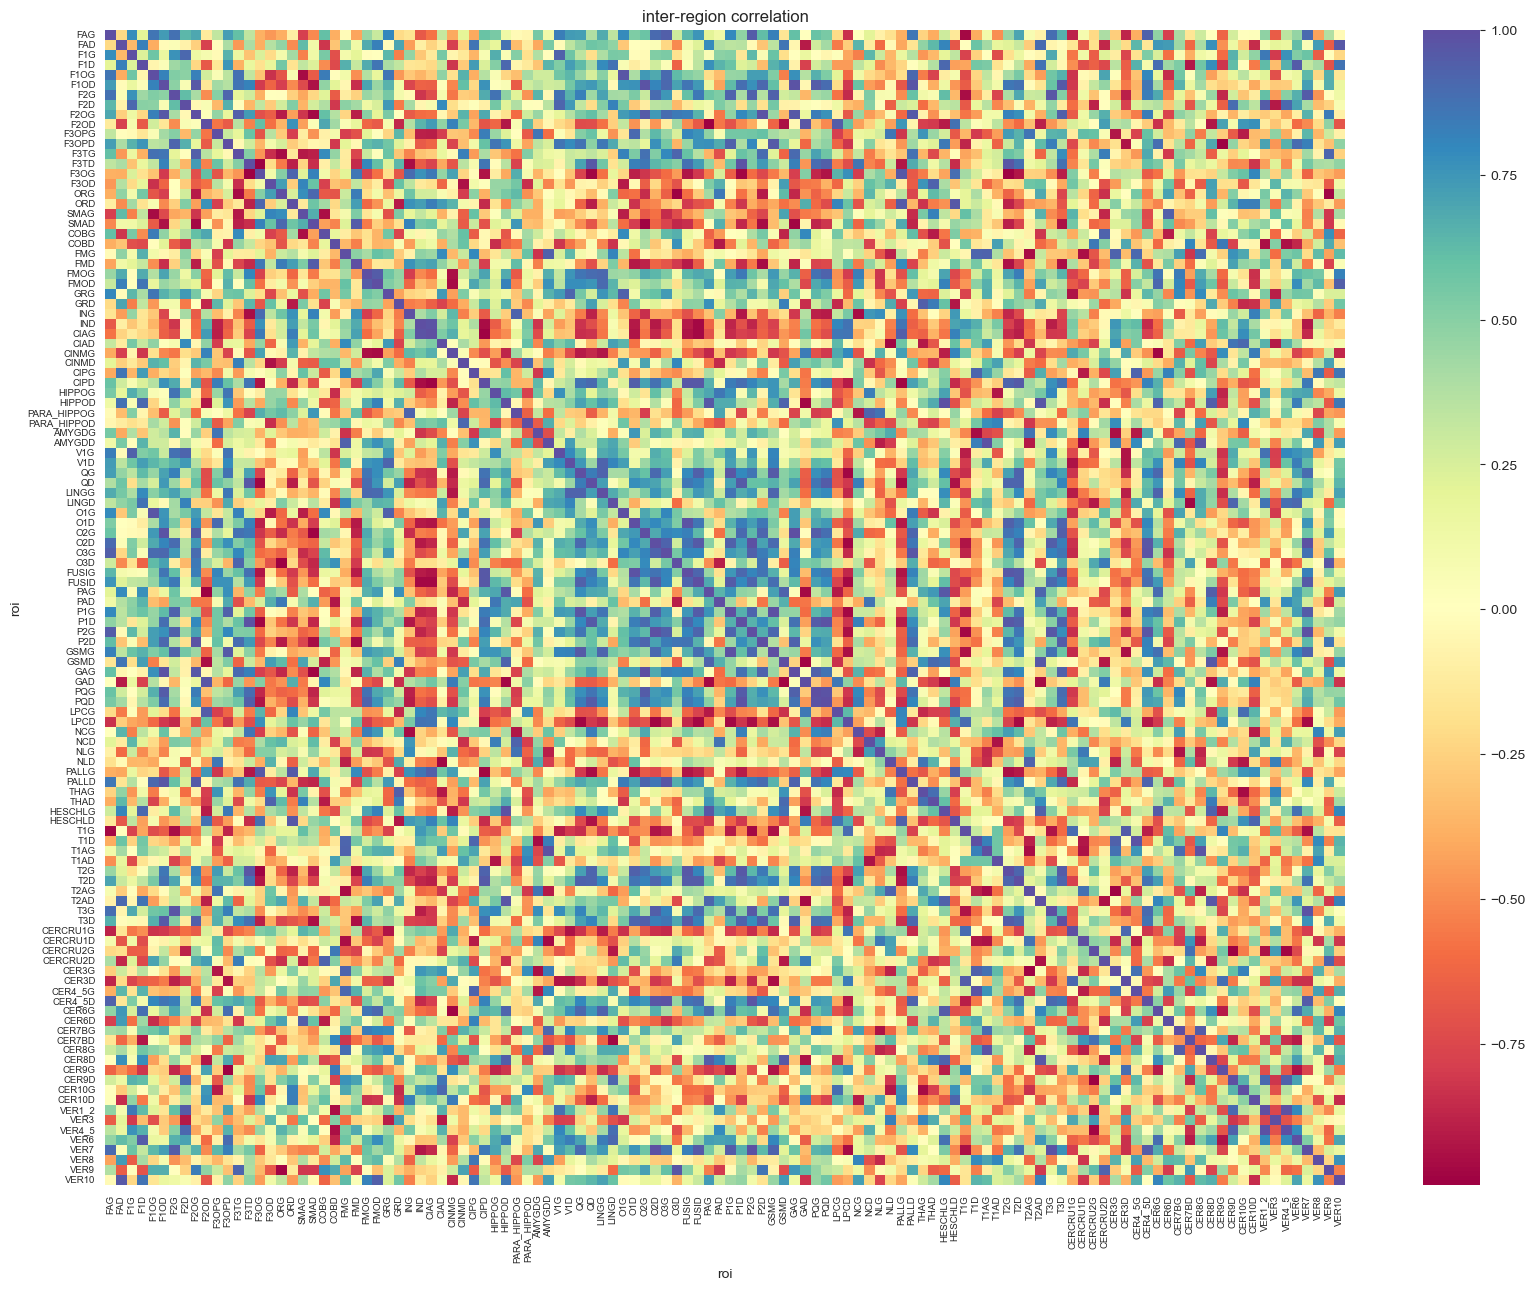

In [14]:
# plot correlation matrix
axis_labels = region_labels[:, 0]
fig, ax = plt.subplots(figsize=(20,15))
sns.heatmap(correlation_matrices_per_patient[timestamp], ax=ax, cmap='Spectral')
ax.set_title("inter-region correlation")
ax.set_xlabel("roi")
ax.set_ylabel("roi")
ax.set_xticks(np.arange(len(regions))+0.5, axis_labels, fontsize="x-small")
ax.set_yticks(np.arange(len(regions))+0.5, axis_labels, fontsize="x-small");

## Compute and visualize Network Graph

In [15]:
# set diagonal to 0 (no correlation of region with itself), compute absolute value to have only positive correlations and set all values <= threshold to 0
for k in np.arange(len(correlation_matrices_per_patient)):
    for l in np.arange(len(regions)):
        correlation_matrices_per_patient[k][l,l] = 0
correlation_matrices_per_patient_abs = np.abs(correlation_matrices_per_patient)
correlation_matrices_per_patient_abs_thresh = correlation_matrices_per_patient_abs * (correlation_matrices_per_patient_abs>correlation_threshold)

In [16]:
# compute network graph
graph = nx.from_numpy_array(correlation_matrices_per_patient_abs_thresh[timestamp])

In [17]:
# compute weights of connections based on correlation
all_weights = []
for (node1, node2, data) in graph.edges(data=True):
    all_weights.append(correlation_matrices_per_patient_abs_thresh[timestamp][node1, node2])

In [18]:
# change centroid positions
files = glob("./Data/centroids/*")
all_centroids = np.concatenate([np.load(file) for file in files], axis=0)
all_centroids_new = all_centroids.copy()
center_x, center_y, center_z = np.array(masked_aal.shape) / 2
for centroid in np.arange(all_centroids.shape[0]):
    # mirror node positions on center of x-Axis
    if all_centroids[centroid, 0] < center_x:
        all_centroids_new[centroid, 0] = center_x+(center_x-(all_centroids[centroid, 0]))
    elif all_centroids[centroid, 0] > center_x:
        all_centroids_new[centroid, 0] = center_x-((all_centroids[centroid, 0])-center_x)
    # mirror node positions on center of y-Axis
    # if all_centroids[centroid, 1] < center_y:
    #     all_centroids_new[centroid, 1] = center_y+(center_y-(all_centroids[centroid, 1]))
    # elif all_centroids[centroid, 1] > center_y:
    #     all_centroids_new[centroid, 1] = center_y-((all_centroids[centroid, 1])-center_y)
    # mirror node positions on center of z-Axis
    if all_centroids[centroid, 2] < center_z:
        all_centroids_new[centroid, 2] = center_z+(center_z-(all_centroids[centroid, 2]))
    elif all_centroids[centroid, 2] > center_z:
        all_centroids_new[centroid, 2] = center_z-((all_centroids[centroid, 2])-center_z)

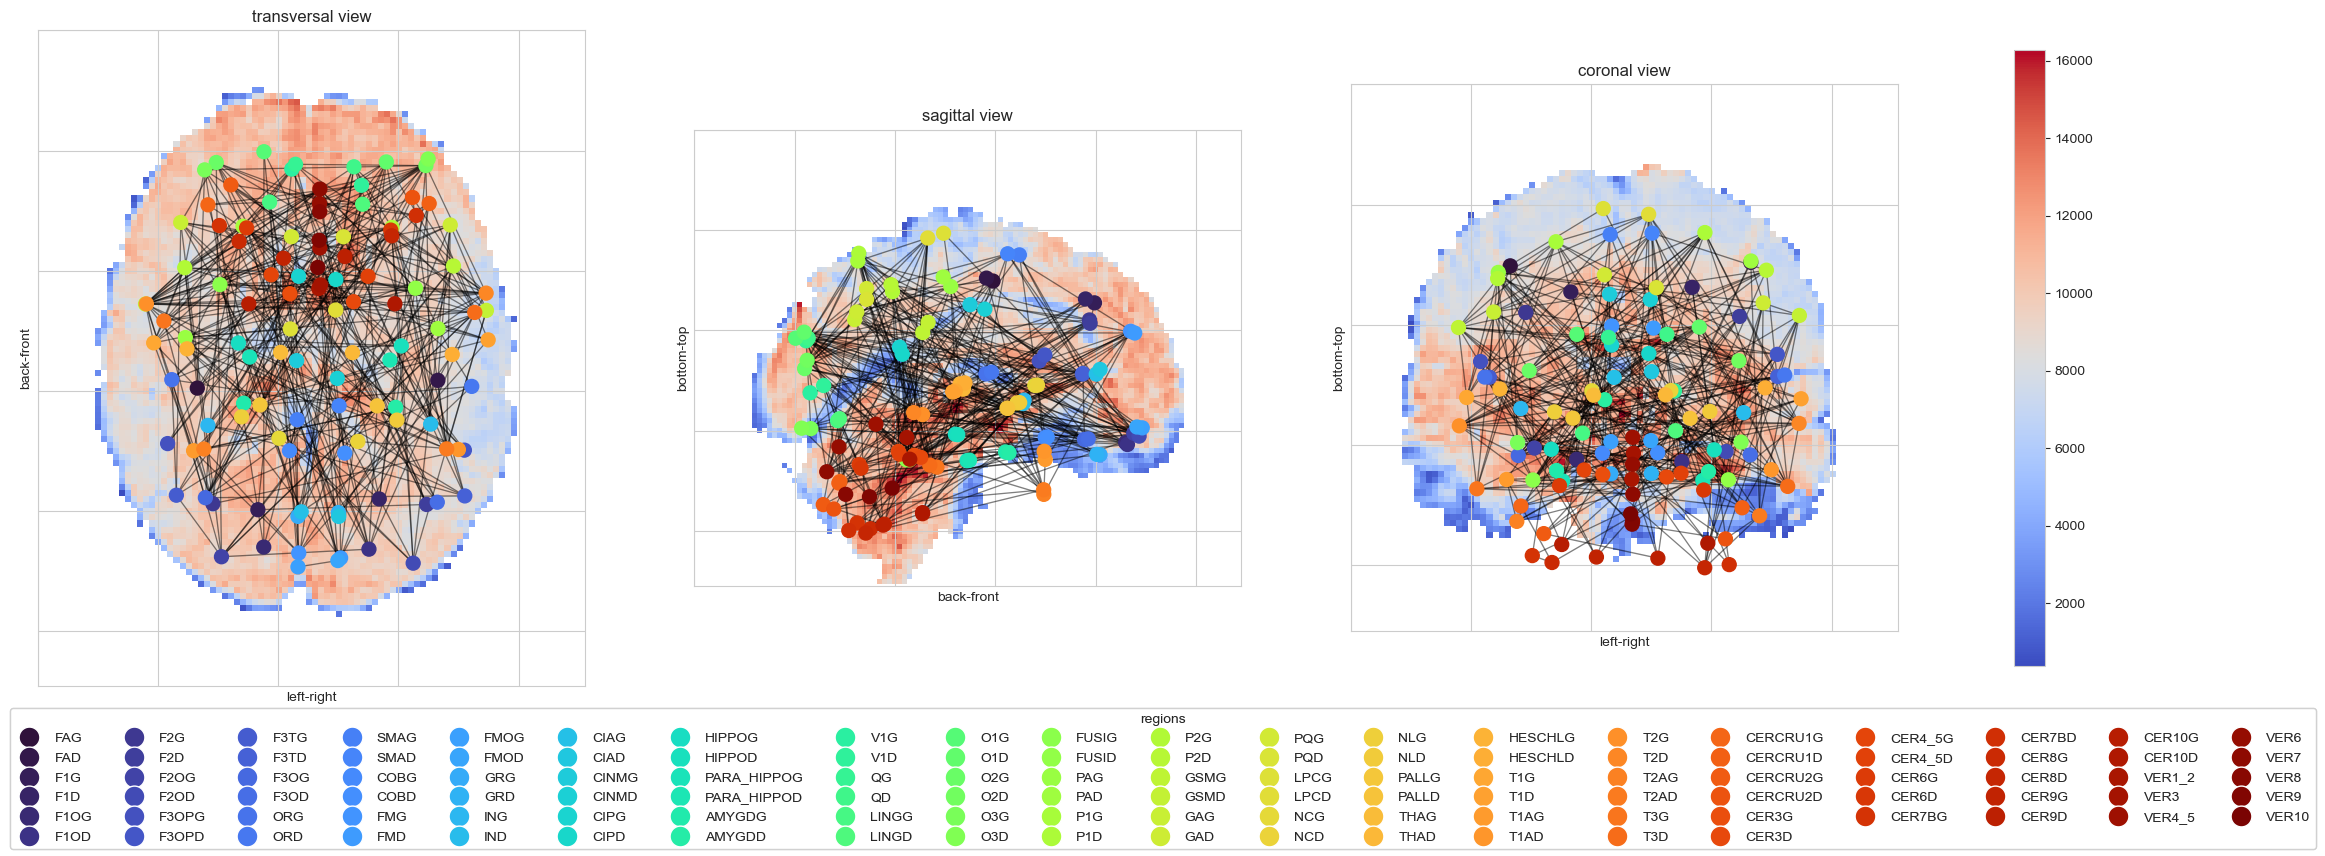

In [19]:
# plot 2D network graph with custom node positions
fig, axs = plt.subplots(1, 3, figsize=(30, 10))
views = [all_centroids_new[:, 0:2], all_centroids_new[:, 1:3], all_centroids_new[:, 0:3:2]]
titles = ["transversal view", "sagittal view", "coronal view"]
pos = []
for ax_num, ax in enumerate(axs):
    image = plot_in_orientation(resampled_img_data_fMRI_masked, orientations[ax_num], slices[ax_num], ax=axs[ax_num], cmap="coolwarm")
    pos.append(views[ax_num])
    nx.draw_networkx_nodes(graph, pos=pos[ax_num], alpha=1, node_size=100, node_color=range(len(regions)), ax=ax, cmap="turbo", )
    nx.draw_networkx_edges(graph, pos=pos[ax_num], alpha=0.5, node_size=100, edge_color="black", width=all_weights, ax=ax)
    ax.set_title(titles[ax_num])
# set Axis labels and limits
axs[0].set_xlabel("left-right")
axs[0].set_ylabel("back-front")
axs[1].set_ylabel("bottom-top")
axs[1].set_xlabel("back-front")
axs[2].set_xlabel("left-right")
axs[2].set_ylabel("bottom-top")
axs[0].set_xlim(0, short)
axs[0].set_ylim(long, 0)
axs[1].set_xlim(0, long)
axs[1].set_ylim(short, 0)
axs[2].set_xlim(0, short)
axs[2].set_ylim(short, 0)
# generate legend
legend_elements = [
    Line2D([0], [0], marker='o', color='w', label=label, markerfacecolor=colors[label_num], markersize=15) for label_num, label in enumerate(list(region_labels[:, 0]))
]
legend = fig.legend(handles = legend_elements, labels=list(region_labels[:, 0]), loc="lower center", title="regions", ncols=20)
fig.add_artist(legend)
cbar = fig.colorbar(image, ax=axs.ravel().tolist(), shrink=0.8)

In [20]:
# image transposing
coronal = np.transpose(resampled_img_data_T1w, [0, 2, 1])
coronal = np.rot90(coronal, 3)
coronal_image = coronal[:, :, coronal_slice]
sagittal = np.transpose(resampled_img_data_T1w, [1, 2, 0])
sagittal = np.rot90(sagittal, 0)
sagittal_image = sagittal[:, :, sagittal_slice]
transversal = np.transpose(resampled_img_data_T1w, [0, 1, 2])
transversal = np.rot90(transversal, 3)
transversal_image = transversal[:, :, transversal_slice]

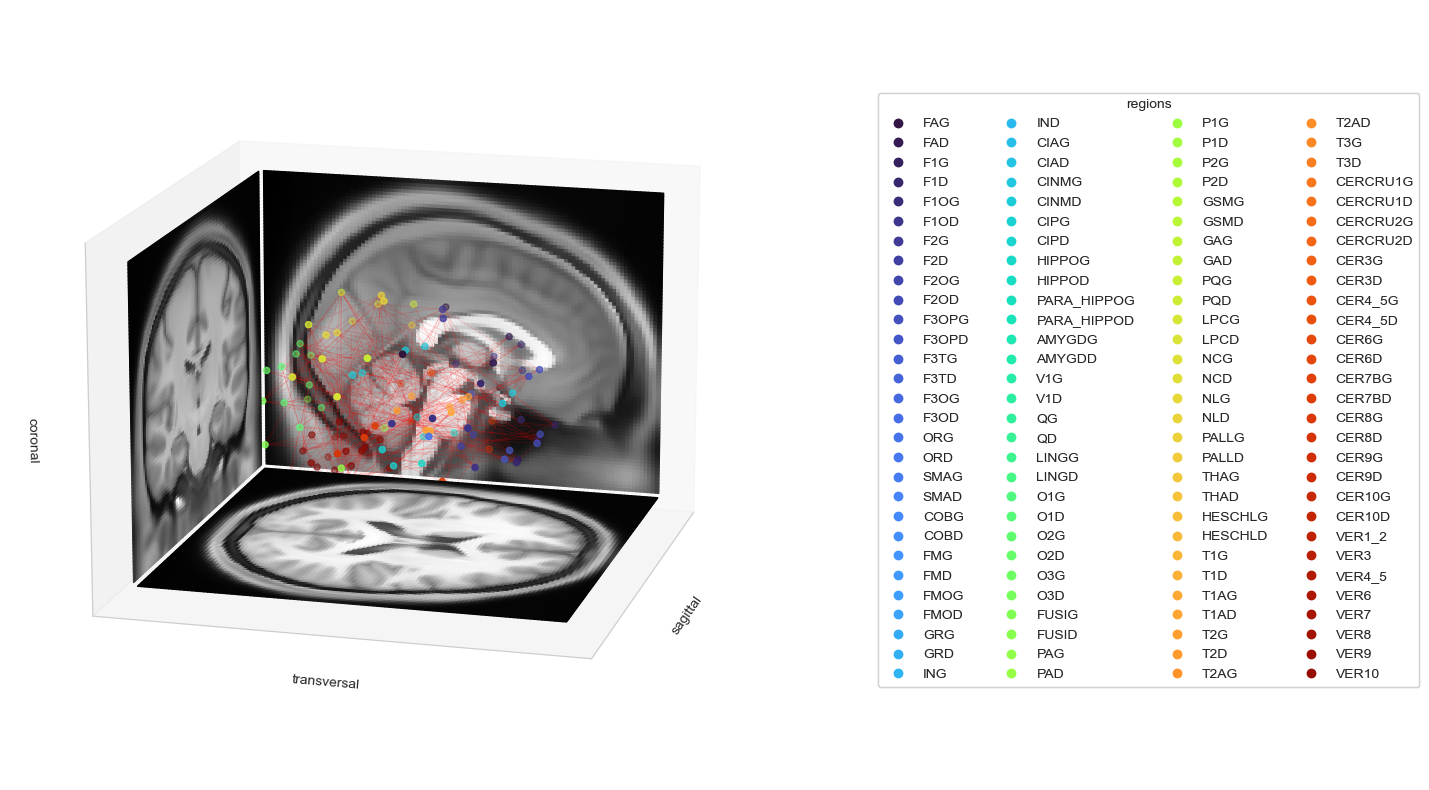

In [21]:
# get positions
pos = all_centroids
node_pos = pos
edge_pos = np.array([(pos[u], pos[v]) for u, v in graph.edges])
# set plot
fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(projection='3d')
# plot background images
x1, y1 = np.meshgrid(np.linspace(0,transversal.shape[1],transversal.shape[1]), np.linspace(0,transversal.shape[0],transversal.shape[0]))
z1 = np.ones(x1.shape)*-1
ax.plot_surface(x1, y1, z1, rstride=1, cstride=1, facecolors=plt.cm.gray(transversal_image/transversal_image.max()), shade=False)
x2, z2 = np.meshgrid(np.linspace(0,coronal.shape[0],coronal.shape[0]), np.linspace(0,coronal.shape[1],coronal.shape[1]))
y2 = np.ones(x2.shape)*-1
ax.plot_surface(x2, y2, z2, rstride=1, cstride=1, facecolors=plt.cm.gray(coronal_image/coronal_image.max()), shade=False)
z3, y3 = np.meshgrid(np.linspace(0,sagittal.shape[1],sagittal.shape[1]), np.linspace(0,sagittal.shape[0],sagittal.shape[0]))
x3 = np.ones(z3.shape)*-1
ax.plot_surface(x3, y3, z3, rstride=1, cstride=1, facecolors=plt.cm.gray(sagittal_image/sagittal_image.max()), shade=False)
# plot nodes
scatter = ax.scatter3D(*node_pos.T, c=regions, s=20, cmap="turbo")
# plot edges
for edge_num in np.arange(edge_pos.shape[0]):
    ax.plot3D(xs=(edge_pos[edge_num, 0, 0], edge_pos[edge_num, 1, 0]), ys=(edge_pos[edge_num, 0, 1], edge_pos[edge_num, 1, 1]), zs=(edge_pos[edge_num, 0, 2], edge_pos[edge_num, 1, 2]), color="red", linewidth=all_weights[edge_num]*0.5, alpha=0.2)
# set viewing angle
ax.view_init(15, 15)
# generate legend
legend = fig.legend(handles = scatter.legend_elements(num=len(regions))[0], labels=list(region_labels[:, 0]), bbox_to_anchor=(1.2, 0.5), loc="right", title="regions", ncols=4)
fig.add_artist(legend)
# set Axis labels and remove ticks
ax.set_xlabel("sagittal")
ax.set_ylabel("transversal")
ax.set_zlabel("coronal")
ax.set_xticks([])
ax.set_yticks([])
ax.set_zticks([]);

In [19]:
# generate single frames for video animation
create_network_graph_frames(resampled_img_data_T1w, (coronal_slice, sagittal_slice, transversal_slice), correlation_matrices_per_patient_abs_thresh, all_centroids, regions, region_labels)

All figures saved.


In [20]:
# generate video
# code adapted based on code by BoboDarph under https://stackoverflow.com/questions/44947505/how-to-make-a-movie-out-of-images-in-python and code under https://note.nkmk.me/en/python-sort-num-str/

image_folder = './Data/video'
video_name = './Data/video.mp4'

images = [img for img in os.listdir(image_folder) if img.endswith(".png")]
images = sorted(images, key=lambda s: int(re.search(r'\d+', s).group()))
frame = cv2.imread(os.path.join(image_folder, images[0]))
height, width, layers = frame.shape

fourcc = cv2.VideoWriter_fourcc(*'h264')

video = cv2.VideoWriter(video_name, fourcc, 12, (width,height))

for image in images:
    video.write(cv2.imread(os.path.join(image_folder, image)))

cv2.destroyAllWindows()
video.release()

# Clustering with kMeans

In [26]:
correlation_matrices_per_patient[0]

array([[ 0.        ,  0.97602941,  0.56591914, ...,  0.36276878,
        -0.37304331, -0.07544337],
       [ 0.97602941,  0.        ,  0.52649268, ...,  0.28033615,
        -0.32910851,  0.02303457],
       [ 0.56591914,  0.52649268,  0.        , ...,  0.71361336,
         0.43965359,  0.22335376],
       ...,
       [ 0.36276878,  0.28033615,  0.71361336, ...,  0.        ,
         0.01996111, -0.47662132],
       [-0.37304331, -0.32910851,  0.43965359, ...,  0.01996111,
         0.        ,  0.74233441],
       [-0.07544337,  0.02303457,  0.22335376, ..., -0.47662132,
         0.74233441,  0.        ]])

In [ ]:
X = np.zeros((len(patients)*len(correlation_matrices_per_patient), int(0.5*len(regions)*(len(regions)-1))))
index = 0
for patient_id in patients:
    patient_num = patients.index(patient_id)
    # extract single patients timeseries
    timeseries = all_timeseries[patient_num]
    # compute correlation between regions in sliding window
    correlation_matrices_per_patient = timeseries_pearson_corr(timeseries, step_width=5, overlap_percentage=0.2)
    for matrix in correlation_matrices_per_patient:
        upper_triangular_indices = np.triu_indices_from(matrix, k=1)
        X[index, :] = matrix[upper_triangular_indices]
        index += 1

KeyboardInterrupt: 